In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure()
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='test loss')
    plt.xlabel('iterations')
    plt.ylabel('losses')
    plt.legend()

    plt.figure()
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='test accuracy')
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.legend()

In [52]:
import librosa
import numpy as np

def extract_features(file_path):
    x, sr = librosa.load(file_path, sr=None)

    result = np.array([])

    mfccs = np.mean(librosa.feature.mfcc(y=x, sr=sr).T, axis=0)
    result = np.hstack((result, mfccs))

    return result

In [65]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

def load_dataset(type, features='mfcc', train_size=0.8):
    dir = r'C:\Users\rupes\OneDrive\Documents\Data Science\Speech Emotion Recognition\audio_dataset'
    
    X = []
    Y = []

    for folder in os.listdir(dir):
        folder_path = os.path.join(dir, folder)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)

                if os.path.isfile(file_path):
                    mfcc = extract_features(file_path)
                    if mfcc is not None:
                        X.append(mfcc)
                        
                        audio_path = file_path.split('\\')[-1] 
                        parts = audio_path.split('.')[0].split('-')

                        if type == 'emotion':
                            Y.append(int(parts[2]))
                        elif type == 'gender':
                            actor_id = int(parts[6])
                            gender = 1 if actor_id % 2 == 0 else 2
                            Y.append(gender)


    X = np.array(X)
    Y = np.array(Y)

    scaler = StandardScaler()
    scaled = scaler.fit_transform(X)

    Y = Y.reshape(-1, 1)
    X = X.reshape(-1, 1, X.shape[1])

    Y = Y - 1

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # num_classes = len(np.unique(Y))
    # y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes)  # Assuming labels are from 1 to 8
    # y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes)
    
    return x_train, y_train, x_test, y_test

In [66]:
# Loading the data
xe_train, ye_train, xe_test, ye_test = load_dataset(type='emotion', features='mfcc')
xg_train, yg_train, xg_test, yg_test = load_dataset(type='gender', features='mfcc')

In [55]:
print('xe_train shape:', xe_train.shape)  # Should be (num_samples, timesteps, features)
print('ye_train shape:', ye_train.shape)  # Should be (num_samples,) for classification
print('Unique labels:', np.unique(ye_train))  

xe_train shape: (1152, 1, 20)
ye_train shape: (1152, 1)
Unique labels: [0 1 2 3 4 5 6 7]


# Emotion Analysis Model using LSTM

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers
# from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(input_shape, num_classes, x_train, y_train, x_test, y_test):
    dropout_rate = 0.2

    model = Sequential([
        tf.keras.layers.LSTM(128, recurrent_dropout=0.2, activation='linear', input_shape=input_shape, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(64, recurrent_dropout=0.2, activation='tanh', return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(64, recurrent_dropout=0.2, activation='linear', return_sequences=False),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Use Adam optimizer with learning rate decay
    initial_learning_rate = 0.0002
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
    )
    
    optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(x_train, y_train, batch_size=128, epochs=1000, validation_data=(x_test, y_test))
    

    plot_history(history)

    print(model.summary())
    result = model.evaluate(x_test, y_test)
    print(result)

    return model


Epoch 1/1000
9/9 [==============================] - 42s 764ms/step - loss: 2.6499 - accuracy: 0.1146 - val_loss: 2.0830 - val_accuracy: 0.1458
Epoch 2/1000
9/9 [==============================] - 0s 58ms/step - loss: 2.3586 - accuracy: 0.1701 - val_loss: 2.0817 - val_accuracy: 0.0729
Epoch 3/1000
9/9 [==============================] - 0s 46ms/step - loss: 2.2082 - accuracy: 0.2188 - val_loss: 2.0813 - val_accuracy: 0.1111
Epoch 4/1000
9/9 [==============================] - 1s 75ms/step - loss: 2.1309 - accuracy: 0.2231 - val_loss: 2.0810 - val_accuracy: 0.1875
Epoch 5/1000
9/9 [==============================] - 1s 76ms/step - loss: 2.0415 - accuracy: 0.2517 - val_loss: 2.0807 - val_accuracy: 0.1701
Epoch 6/1000
9/9 [==============================] - 1s 81ms/step - loss: 2.0265 - accuracy: 0.2491 - val_loss: 2.0802 - val_accuracy: 0.1562
Epoch 7/1000
9/9 [==============================] - 1s 68ms/step - loss: 2.0716 - accuracy: 0.2474 - val_loss: 2.0794 - val_accuracy: 0.1597
Epoch 8/100

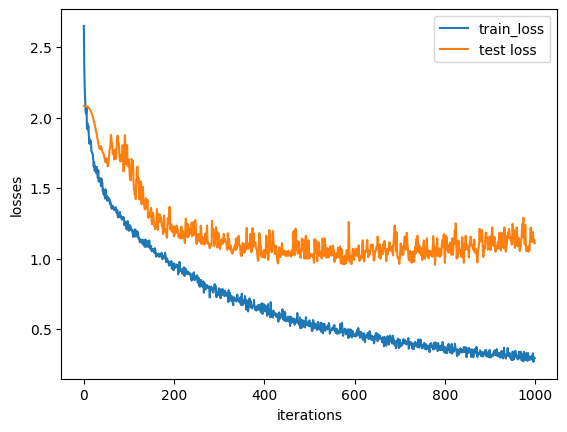

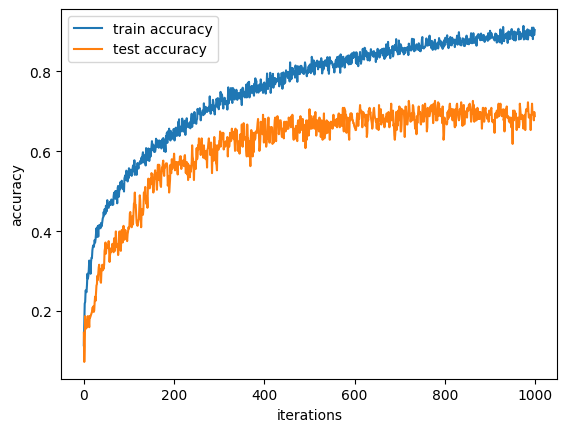

In [61]:
input_shape = (xe_train.shape[1], xe_train.shape[2]) 
num_classes = 8

emotion_model = build_lstm_model(input_shape, num_classes, xe_train, ye_train, xe_test, ye_test)

In [62]:
emotion_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 1, 128)            76288     
                                                                 
 batch_normalization_33 (Bat  (None, 1, 128)           512       
 chNormalization)                                                
                                                                 
 dropout_33 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_34 (LSTM)              (None, 1, 64)             49408     
                                                                 
 batch_normalization_34 (Bat  (None, 1, 64)            256       
 chNormalization)                                                
                                                                 
 dropout_34 (Dropout)        (None, 1, 64)           

# Gender Classification Model

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers
# from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_gender_model(input_shape, num_classes, x_train, y_train, x_test, y_test):
    dropout_rate = 0.2

    model = Sequential([
        tf.keras.layers.LSTM(128, recurrent_dropout=0.2, activation='linear', input_shape=input_shape, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(64, recurrent_dropout=0.2, activation='tanh', return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(64, recurrent_dropout=0.2, activation='linear', return_sequences=False),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Use Adam optimizer with learning rate decay
    # initial_learning_rate = 0.0002
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
    # )
    
    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.0002)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model and return the history
    history = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_test, y_test))

    # Plot the history (assuming `plot_history` is defined elsewhere)
    plot_history(history)

    # Model summary and result on test_data
    print(model.summary())
    result = model.evaluate(x_test, y_test)
    print(result)

    return model


Epoch 1/100
5/5 [==============================] - 8s 175ms/step - loss: 0.8119 - accuracy: 0.5998 - val_loss: 0.6933 - val_accuracy: 0.5312
Epoch 2/100
5/5 [==============================] - 0s 21ms/step - loss: 0.6215 - accuracy: 0.7075 - val_loss: 0.6919 - val_accuracy: 0.6597
Epoch 3/100
5/5 [==============================] - 0s 23ms/step - loss: 0.4819 - accuracy: 0.7917 - val_loss: 0.6897 - val_accuracy: 0.6111
Epoch 4/100
5/5 [==============================] - 0s 22ms/step - loss: 0.4017 - accuracy: 0.8273 - val_loss: 0.6874 - val_accuracy: 0.5243
Epoch 5/100
5/5 [==============================] - 0s 22ms/step - loss: 0.3602 - accuracy: 0.8620 - val_loss: 0.6844 - val_accuracy: 0.5347
Epoch 6/100
5/5 [==============================] - 0s 23ms/step - loss: 0.3146 - accuracy: 0.8759 - val_loss: 0.6816 - val_accuracy: 0.5868
Epoch 7/100
5/5 [==============================] - 0s 22ms/step - loss: 0.3030 - accuracy: 0.8785 - val_loss: 0.6782 - val_accuracy: 0.6840
Epoch 8/100
5/5 [==

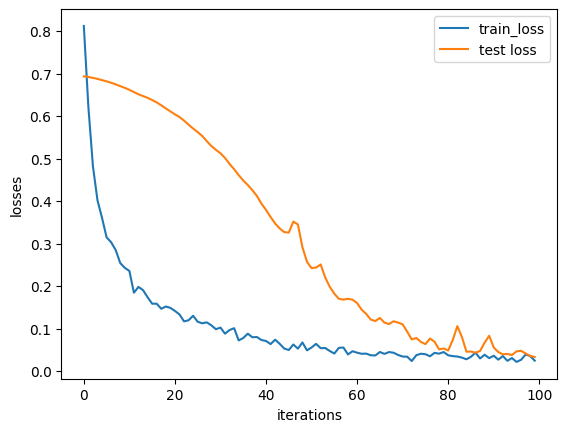

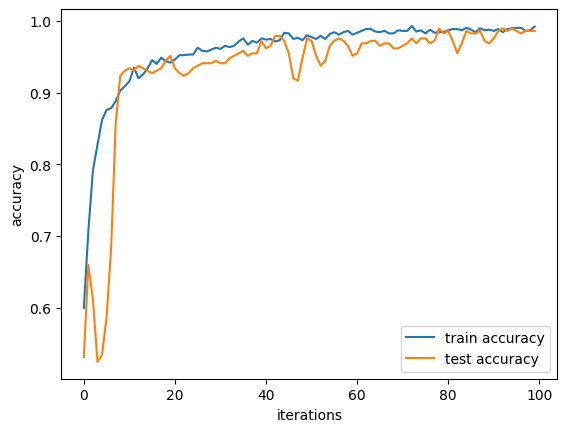

In [70]:
input_shape = (1, 20)
num_classes = 2

gender_model = build_gender_model(input_shape, num_classes, xg_train, yg_train, xg_test, yg_test)

In [71]:
gender_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 1, 128)            76288     
                                                                 
 batch_normalization_42 (Bat  (None, 1, 128)           512       
 chNormalization)                                                
                                                                 
 dropout_42 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_43 (LSTM)              (None, 1, 64)             49408     
                                                                 
 batch_normalization_43 (Bat  (None, 1, 64)            256       
 chNormalization)                                                
                                                                 
 dropout_43 (Dropout)        (None, 1, 64)           

In [ ]:
from sklearn.preprocessing import scale

def predict_emotion_gender(audio_file):
        
        # Extract features
        feature_vector = extract_features(audio_file)
        # print("Extracted Features:", feature_vector)  # Debugging line
        

        scaler = StandardScaler()
        scaled = scaler.fit_transform(feature_vector)

        feature_vector = feature_vector.reshape(-1, 1, feature_vector.shape[1])

        # Predict emotion
        emotion_pred = emotion_model.predict(feature_vector)
        predicted_emotion = np.argmax(emotion_pred, axis=1)[0]

        # Predict Gender 
        gender_pred = gender_model.predict(feature_vector)
        predicted_gender = np.argmax(gender_pred, axis=1)[0]

        # Map the predicted values back to their respective categories
        emotion_labels = {0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}
        gender_labels = {0: 'female', 1: 'male'}

        # Output the results
        print(f"Predicted Emotion: {emotion_labels[predicted_emotion]}")
        print(f"Predicted Gender: {gender_labels[predicted_gender]}")


# Test the model with an audio file
audio_path = r'audio_dataset\Actor_01\03-01-08-01-02-02-01.wav'
predict_emotion_gender(audio_path)